In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [15]:
fielding = pd.read_csv('Data/Lahman/Fielding.csv')
batting = pd.read_csv('Data/Lahman/Batting.csv')
pitching = pd.read_csv('Data/Lahman/Pitching.csv')
players = pd.read_csv('Data/Lahman/People.csv', encoding='latin1')
salaries = pd.read_csv('Data/Lahman/Salaries.csv')
survival_data = pd.read_csv('SurvivalData.csv')

pitching_cols = [
    'playerID', 'yearID', 'teamID', 'stint', 'W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 
    'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'WP', 'BK', 'BFP', 'GF'
]

# Combine batting and fielding columns for position players
batting_cols = [
    'playerID', 'yearID', 'teamID', 'stint', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 
    'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP'
]
fielding_cols = [
    'playerID', 'yearID', 'teamID', 'stint', 'POS', 'G', 'GS', 'InnOuts', 'PO', 'A', 
    'E', 'DP', 'PB', 'WP', 'SB', 'CS', 'ZR'
]

pitching = pitching[pitching_cols]
batting = batting[batting_cols]
fielding = fielding[fielding_cols]
players = players[['playerID', 'birthYear']]

fielding = (
    fielding.groupby(['playerID', 'yearID', 'teamID', 'stint'])
    .agg('sum')
    .reset_index()
)

position_players = pd.merge(batting, fielding, on=['playerID', 'yearID', 'teamID'], how='outer')
position_players = pd.merge(position_players, salaries.drop('lgID',axis=1), on=['playerID', 'yearID', 'teamID'], how='left')
position_players = position_players.drop(columns=['PB', 'WP', 'SB_y', 'CS_y', 'ZR'])
position_players = position_players.merge(survival_data[['playerID', 'yearID', 'decline_event', 'time_to_event']],
                                               on=['playerID', 'yearID'], how='left')

pitchers = pd.merge(pitching, salaries, on=['playerID', 'yearID', 'teamID'], how='left')

C:\Users\whawkins.RHIT-R90Y2R48\AppData\Local\Temp\ipykernel_5876\2109662462.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .agg('sum')


In [16]:
def prepare_salary_prediction_dataset(df):
    df = df.sort_values(['playerID', 'yearID'])
    
    # Create a list to store valid rows
    valid_rows = []
    
    # Group by player
    for _, player_group in df.groupby('playerID'):
        # Iterate through player's seasons
        for i in range(1, len(player_group)):
            # Previous season's stats
            prev_stats = player_group.iloc[i-1]
            # Current season's salary
            current_salary = player_group.iloc[i]['salary']
            
            # Create a row with previous year's stats and current year's salary
            row = prev_stats.copy()
            row['target_salary'] = current_salary
            valid_rows.append(row)
    
    # Convert to DataFrame
    prepared_df = pd.DataFrame(valid_rows)
    
    return prepared_df

In [20]:
# Prepare the dataset
position_players_f = position_players[(position_players['yearID'] >= 1985) & (position_players['yearID'] <= 2016)]
position_players_f = position_players_f.dropna(subset=['salary', 'decline_event'])

# Create dataset where each row is previous year's stats and current year's salary
salary_prediction_df = prepare_salary_prediction_dataset(position_players_f)

# Select features and target
X = salary_prediction_df.drop(columns=['playerID', 'yearID', 'teamID', 'salary', 'target_salary', 'stint_x', 'stint_y'])
y = salary_prediction_df['target_salary']

# Split and scale
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [21]:
# Model
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                            param_grid=param_grid,
                            cv=5,
                            scoring='r2',
                            n_jobs=-1,
                            return_train_score=True)

grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))
print("Optimal number of trees:", grid_search.best_params_['n_estimators'])

Mean Squared Error: 10797208531086.762
R-squared: 0.41658993078407613
Optimal number of trees: 500


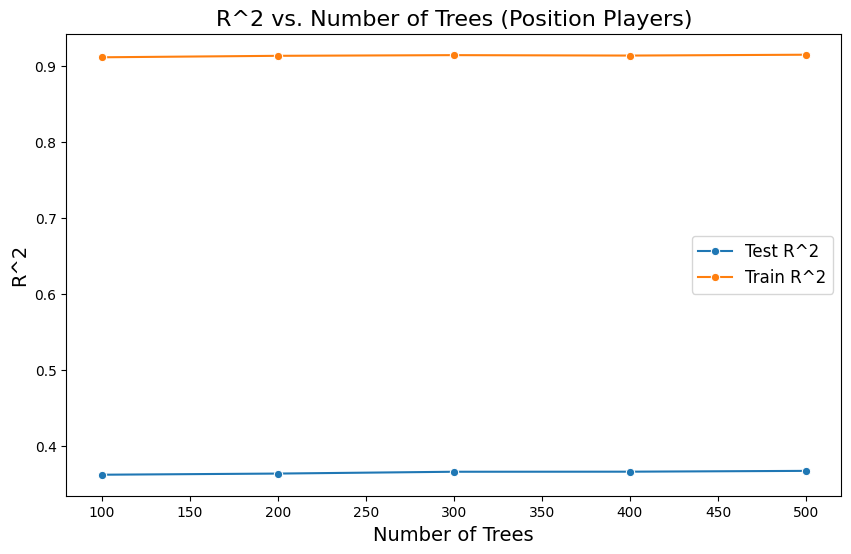

In [22]:
cv_results = grid_search.cv_results_
mean_test_r2 = cv_results['mean_test_score']
mean_train_r2 = cv_results['mean_train_score']
n_estimators = param_grid['n_estimators']

# Create a plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=n_estimators, y=mean_test_r2, label="Test R^2", marker='o')
sns.lineplot(x=n_estimators, y=mean_train_r2, label="Train R^2", marker='o')

plt.title("R^2 vs. Number of Trees (Position Players)", fontsize=16)
plt.xlabel("Number of Trees", fontsize=14)
plt.ylabel("R^2", fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [19]:
X_original = salary_prediction_df.drop(columns=['playerID', 'yearID', 'teamID', 'salary', 'target_salary', 'stint_x', 'stint_y'])

# Feature set with new columns
X_with_new_features = salary_prediction_df.drop(columns=['playerID', 'yearID', 'teamID', 'salary', 'target_salary', 'stint_x', 'stint_y']).copy()
X_with_new_features['decline_event'] = salary_prediction_df['decline_event']
X_with_new_features['time_to_event'] = salary_prediction_df['time_to_event']

# Scale features
X_original_scaled = StandardScaler().fit_transform(X_original)
X_new_scaled = StandardScaler().fit_transform(X_with_new_features)

# Split data
X_orig_train, X_orig_test, y_train, y_test = train_test_split(X_original_scaled, y, test_size=0.2)
X_new_train, X_new_test, _, _ = train_test_split(X_new_scaled, y, test_size=0.2)

# Train models
model_original = RandomForestRegressor(n_estimators=100)
model_new = RandomForestRegressor(n_estimators=100)

model_original.fit(X_orig_train, y_train)
model_new.fit(X_new_train, y_train)

# Evaluate models
y_pred_original = model_original.predict(X_orig_test)
y_pred_new = model_new.predict(X_new_test)

print("Original Model Metrics:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_original))
print("R-squared:", r2_score(y_test, y_pred_original))

print("\nNew Model Metrics:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_new))
print("R-squared:", r2_score(y_test, y_pred_new))

# Feature importance for new model
feature_names = list(X_with_new_features.columns)
importances = model_new.feature_importances_
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

print("\nFeature Importances:")
for name, importance in feature_importance:
    print(f"{name}: {importance}")

Original Model Metrics:
Mean Squared Error: 9421300094621.21
R-squared: 0.3551616349194193

New Model Metrics:
Mean Squared Error: 15969006208140.785
R-squared: -0.09299435871893436

Feature Importances:
PO: 0.06660129708467585
BB: 0.057526682132277344
SO: 0.05312177916369719
A: 0.05088621040017005
H: 0.043738262271734274
G_x: 0.04285062945416857
AB: 0.04248184135449001
R: 0.041862982541220645
time_to_event: 0.04185347794020331
DP: 0.041541429466859486
RBI: 0.04150835350128893
2B: 0.040655004793651146
InnOuts: 0.04055109546693166
E: 0.03804625156751354
GIDP: 0.03790444942246502
SB_x: 0.036136415963078206
HR: 0.035954374649394154
G_y: 0.035194807626336755
HBP: 0.032172092304466715
SF: 0.03176105197037039
IBB: 0.03047425077053959
CS_x: 0.029716885839544394
3B: 0.028933604703599236
GS: 0.028238363362589853
SH: 0.026671018266380755
decline_event: 0.0036173879823529504


In [ ]:
# Prepare the dataset
pitchers_f = pitchers[(pitchers['yearID'] >= 1985) & (pitchers['yearID'] <= 2016)]
pitchers_f = pitchers_f.dropna(subset=['salary'])

# Create dataset where each row is previous year's stats and current year's salary
salary_prediction_df = prepare_salary_prediction_dataset(pitchers_f)

# Select features and target
X = salary_prediction_df.drop(columns=['playerID', 'yearID', 'teamID', 'salary', 'target_salary', 'stint_x', 'stint_y'])
y = salary_prediction_df['target_salary']

# Split and scale
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                            param_grid=param_grid,
                            cv=5,
                            scoring='r2',
                            n_jobs=-1,
                            return_train_score=True)

grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))
print("Optimal number of trees:", grid_search.best_params_['n_estimators'])

In [ ]:
cv_results = grid_search.cv_results_
mean_test_r2 = cv_results['mean_test_score']
mean_train_r2 = cv_results['mean_train_score']
n_estimators = param_grid['n_estimators']

# Create a plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=n_estimators, y=mean_test_r2, label="Test R^2", marker='o')
sns.lineplot(x=n_estimators, y=mean_train_r2, label="Train R^2", marker='o')

plt.title("R^2 vs. Number of Trees (Pitchers)", fontsize=16)
plt.xlabel("Number of Trees", fontsize=14)
plt.ylabel("R^2", fontsize=14)
plt.legend(fontsize=12)
plt.show()